# Advanced Hybrid LSTM (ALSTM) Model
## Multi-Branch Architecture: CNN + LSTM + Transformer/Attention

This notebook builds a hybrid deep learning model for time-series forecasting that combines:
- **CNN Branch**: Captures local patterns and trends
- **LSTM Branch**: Captures temporal dependencies
- **Transformer/Attention Branch**: Captures long-range dependencies

All branches are fused together for final prediction.

## 1. Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.19.0
GPU Available: []


## 2. Load Data

In [3]:
# Load the .npy files
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Print shapes to confirm dimensions
print("Data Shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Extract dimensions
num_samples, time_steps, num_features = X_train.shape
print(f"\nTime Steps: {time_steps}")
print(f"Number of Features: {num_features}")

Data Shapes:
X_train: (32728, 60, 23)
X_test: (8183, 60, 23)
y_train: (32728,)
y_test: (8183,)

Time Steps: 60
Number of Features: 23


## 3. Build Multi-Branch Hybrid Model

### Architecture Overview:
```
Input (60, num_features)
    |
    +-- Branch 1: CNN --> MaxPooling --> Flatten
    |
    +-- Branch 2: LSTM
    |
    +-- Branch 3: MultiHeadAttention --> GlobalAveragePooling
    |
    v
Concatenate --> Dense --> Dropout --> Output
```

In [4]:
def build_hybrid_model(time_steps, num_features):
    """
    Build Advanced Hybrid LSTM Model with CNN, LSTM, and Transformer/Attention branches.
    
    Args:
        time_steps: Number of time steps in the input sequence (60)
        num_features: Number of features per time step
    
    Returns:
        Compiled Keras model
    """
    # Input Layer
    input_layer = layers.Input(shape=(time_steps, num_features), name='input')
    
    # ========== BRANCH 1: CNN ==========
    # Captures local patterns and trends
    cnn_branch = layers.Conv1D(
        filters=64, 
        kernel_size=3, 
        activation='relu',
        padding='same',
        name='cnn_conv1d'
    )(input_layer)
    cnn_branch = layers.MaxPooling1D(pool_size=2, name='cnn_maxpool')(cnn_branch)
    cnn_branch = layers.Flatten(name='cnn_flatten')(cnn_branch)
    
    # ========== BRANCH 2: LSTM ==========
    # Captures temporal dependencies
    lstm_branch = layers.LSTM(
        64, 
        return_sequences=False,
        name='lstm'
    )(input_layer)
    
    # ========== BRANCH 3: Transformer/Attention ==========
    # Captures long-range dependencies
    attention_branch = layers.MultiHeadAttention(
        num_heads=4, 
        key_dim=16,
        name='multihead_attention'
    )(input_layer, input_layer)  # Self-attention
    attention_branch = layers.GlobalAveragePooling1D(name='attention_pooling')(attention_branch)
    
    # ========== FUSION LAYER ==========
    # Concatenate all branch outputs
    fusion = layers.Concatenate(name='fusion_concat')([cnn_branch, lstm_branch, attention_branch])
    
    # Dense layers for final processing
    fusion = layers.Dense(64, activation='relu', name='fusion_dense')(fusion)
    fusion = layers.Dropout(0.2, name='fusion_dropout')(fusion)
    
    # Output Layer (Regression)
    output = layers.Dense(1, activation='linear', name='output')(fusion)
    
    # Create model
    model = models.Model(inputs=input_layer, outputs=output, name='Advanced_Hybrid_LSTM')
    
    return model

In [5]:
# Build the model
model = build_hybrid_model(time_steps, num_features)

# Display model architecture
model.summary()

Model: "Advanced_Hybrid_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 60, 23)    │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_conv1d (Conv1D) │ (None, 60, 64)    │      4,480 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_maxpool         │ (None, 30, 64)    │          0 │ cnn_conv1d[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attention │ (None, 60, 23)    │      6,103 │ input[0][0],      │
│ (MultiHeadAttentio… │                   │            │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_flatten         │ (None, 1920)      │          0 │ cnn_maxpool[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     22,528 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_pooling   │ (None, 23)        │          0 │ multihead_attent… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_concat       │ (None, 2007)      │          0 │ cnn_flatten[0][0… │
│ (Concatenate)       │                   │            │ lstm[0][0],       │
│                     │                   │            │ attention_poolin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dense        │ (None, 64)        │    128,512 │ fusion_concat[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dropout      │ (None, 64)        │          0 │ fusion_dense[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ fusion_dropout[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 161,688 (631.59 KB)

 Trainable params: 161,688 (631.59 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Compile the Model

In [6]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',  # Mean Squared Error
    metrics=['mae']  # Mean Absolute Error
)

print("Model compiled successfully!")

Model compiled successfully!


## 5. Train the Model

In [7]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train the model
print("Starting training...\n")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

print("\nTraining completed!")

Starting training...

Epoch 1/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.3128 - mae: 0.4124 - val_loss: 0.1560 - val_mae: 0.2918
Epoch 2/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.1492 - mae: 0.2885 - val_loss: 0.1398 - val_mae: 0.2693
Epoch 3/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.1414 - mae: 0.2787 - val_loss: 0.1408 - val_mae: 0.2755
Epoch 4/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.1342 - mae: 0.2719 - val_loss: 0.1629 - val_mae: 0.2940
Epoch 5/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.1310 - mae: 0.2680 - val_loss: 0.1575 - val_mae: 0.2908
Epoch 6/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 0.1289 - mae: 0.2666 - val_loss: 0.1400 - val_mae: 0.2674
Epoch 7/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.1263 - mae: 0.2628 - val_loss: 0.1405 - val_mae: 0.2692
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.

Training completed!


## 6. Evaluate the Model

In [8]:
# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print("\n" + "="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print("="*50)


MODEL EVALUATION RESULTS
Test Loss (MSE): 0.1398
Test MAE: 0.2693


## 7. Visualize Training History

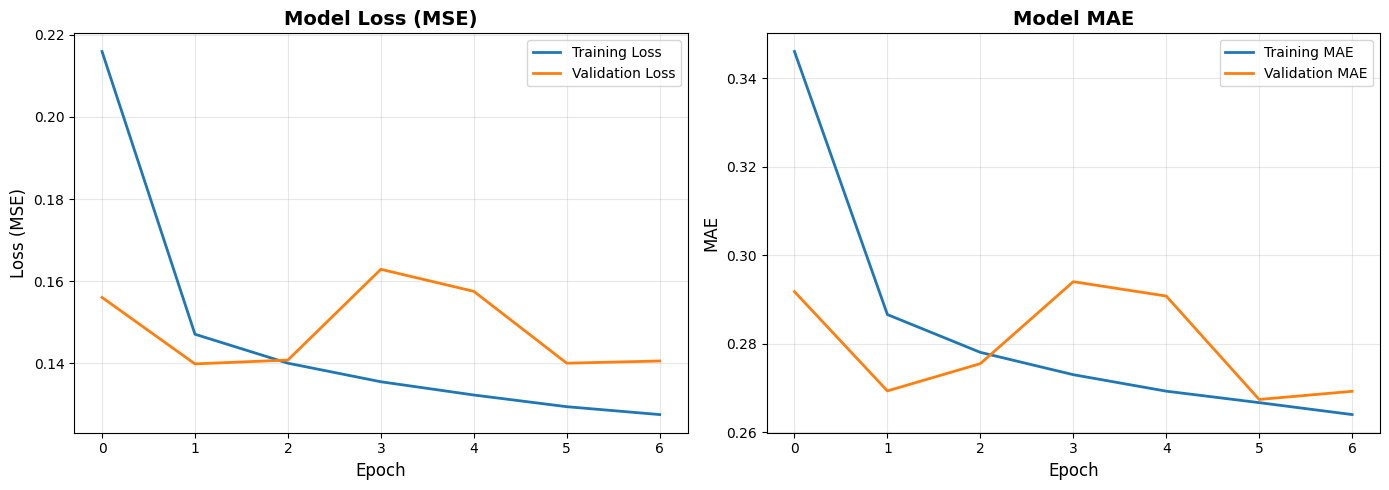

Training history plot saved as 'training_history.png'


In [9]:
# Plot Training vs Validation Loss
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss (MSE)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.title('Model MAE', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plot saved as 'training_history.png'")

## 8. Make Predictions and Visualize Results

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


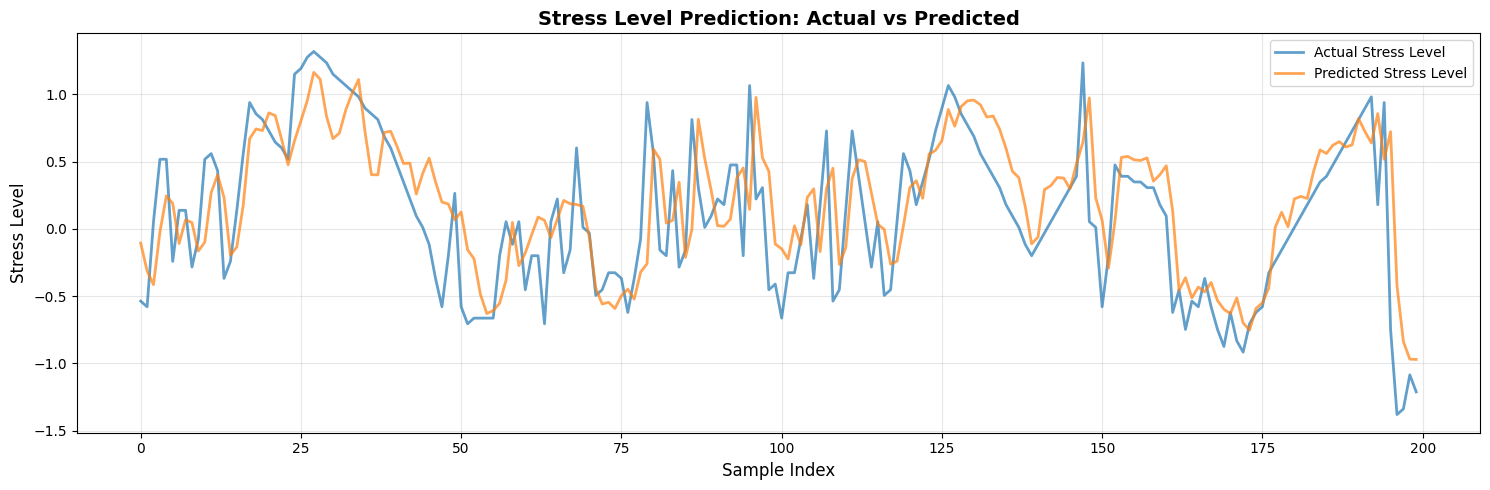

Prediction plot saved as 'predictions_vs_actual.png'


In [10]:
# Make predictions
y_pred = model.predict(X_test)

# Plot predictions vs actual values (first 200 samples)
plt.figure(figsize=(15, 5))
sample_size = min(200, len(y_test))

plt.plot(y_test[:sample_size], label='Actual Stress Level', linewidth=2, alpha=0.7)
plt.plot(y_pred[:sample_size], label='Predicted Stress Level', linewidth=2, alpha=0.7)
plt.title('Stress Level Prediction: Actual vs Predicted', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Stress Level', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

print("Prediction plot saved as 'predictions_vs_actual.png'")

## 9. Calculate Additional Metrics

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n" + "="*50)
print("DETAILED PERFORMANCE METRICS")
print("="*50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print("="*50)


DETAILED PERFORMANCE METRICS
Mean Squared Error (MSE):  0.1398
Root Mean Squared Error (RMSE): 0.3739
Mean Absolute Error (MAE): 0.2693
R² Score: 0.8642


## 10. Save the Model

In [ ]:
# Save the trained model in native Keras format
model.save('advanced_hybrid_lstm_model.keras')
print("Model saved as 'advanced_hybrid_lstm_model.keras'")

# Note: If you want to export for TFLite/TFServing, use:
# model.export('advanced_hybrid_lstm_model_savedmodel')

Model saved as 'advanced_hybrid_lstm_model.keras'


: 

## Summary

This notebook successfully implemented an **Advanced Hybrid LSTM (ALSTM)** model with three parallel branches:

1. **CNN Branch**: Extracts local temporal patterns using 1D convolutions
2. **LSTM Branch**: Captures sequential dependencies and temporal dynamics
3. **Transformer/Attention Branch**: Learns long-range dependencies through multi-head attention

The model uses:
- **Functional API** for flexible multi-branch architecture
- **Early Stopping** to prevent overfitting
- **Adam Optimizer** with MSE loss for regression
- **Fusion Layer** to combine insights from all branches

This hybrid approach leverages the strengths of multiple architectures for robust time-series forecasting.